# ODE models implementation in Julia plus experimental data Versus Models
This file contains ODE model simulation with measurements.

In [3]:
# Simulator versurs real data
# Author: Madhusudhan Pandey

In [13]:
# Introducing packages
using DataFrames
using CSV
using Plots; pyplot()
using LaTeXStrings
using JLD
using LinearAlgebra
using NLsolve
using Statistics
using DifferentialEquations
df=CSV.read("realdata.csv")
#load If, It, Twc
df_input = df[70:653, [:Column6, :Column13, :Column11 ]]
df_output = df[70:653, [:Column7, :Column8]]
df_water_temp = df[70:653, [:Column10, :Column9]]
If_s, It_s, Twc_s = df_input[1],df_input[2],df_input[3]
Ts_meas_s, TFe_meas_s = df_output[1], df_output[2]
Tac_s, Tah_s = df_water_temp[1],df_water_temp[2]
# All data are vectors of strings and missing, so converting
# it back to float64
#
# N measurement data are used
N = 584
#
If,It,Twc,Ts_m,TFe_m =zeros(N),zeros(N),zeros(N),zeros(N),zeros(N)
Tac_m, Tah_m = zeros(N), zeros(N)
for i in range(1,step=1,N)
    If[i]=parse(Float64, If_s[i])
    It[i]=parse(Float64, It_s[i])
    Twc[i]=parse(Float64, Twc_s[i])
    Ts_m[i]=parse(Float64, Ts_meas_s[i])
    TFe_m[i]=parse(Float64, TFe_meas_s[i])
    Tac_m[i]=parse(Float64, Tac_s[i])
    Tah_m[i]=parse(Float64, Tah_s[i])
end

# Subsampling measurements
idx = 1:15:N;

In [5]:
# If, imported from CSV file
# It, imported from CSV file
# Twc, imported from CSV file
QdFes = 212.
Wdf = 528.
Qdfs = 0.8*Wdf # Efficient heating in air gap due to friction
mdw = 48.51
mda = 44.28;

pa = 1.01e5 # Atmospheric pressure , Pa
#
# Heat capacities
chpa = 1.012#1.15 # Specific heat capacity air , kJ.kg-1.K-1  
chpw = 4.1813#4.2 # Specific heat capacity water , kJ.kg-1.K-1 
chpCu = 0.385#0.385 # Specific heat capacity copper , kJ.kg-1.K -1 
chpFe = 0.412#0.465 # Specific heat capacity iron , kJ.kg-1.K-1 
#
# Metal massses
mr = 9260. # Mass of copper in rotor , kg
ms = 6827. # Mass of copper in stator , kg
mFe = 71200. # Mass of iron in stator , kg
#
# Specific volumes (inverse of density)
VhCu = 0.112e-3 # Specific volume of copper , m3/kg 
VhFe = 0.127e-3 # Specific volume of iron , m3/kg 
#
# Resulting volumes
Vr = mr*VhCu # Rotor copper volume , m3  
Vs = ms*VhCu # Stator copper volume , m3 
VFe = mFe*VhFe # Stator iron volume , m3 
#
# Heat transfer (heat transfer coefficient x area), fluids to solid
hAax = 55.6 # Heat transfer from air to solid, kW/K
hAwx = 222. # Heat transfer from water to solid, kW/K
#
# Overall heat transfer (overall heat transfer coeffcients x area)
UAx = 1/(1/hAax+1/hAwx) # Overall heat transfer air-to-water, kW/K
#UAx=44.46=UPLx if Lx=1m then Up=44.46
Up=44.46 # "Product of overall heat transfer and perimeter"
UAr2d = 2.96 #2.835  #2.7 # Heat transfer, rotor copper to air gap, kW/K 
UAs2Fe = 18 #19.#20. # Heat transfer, stator copper to stator iron, kW/K 
UAFe2a = 12.87 #13.585 # 14.285 # 14.3 # Heat transfer, rotor iron to hot air, kW/K 

#
# Stanton numbers for heat exchanger
NSta = UAx/chpa/(mda)
NStw = UAx/chpw/(mdw)
NStd = NStw - NSta
#
# Enthalpies of formation
Hha_o = 0. # Enthalpy of formation air, kJ/kg
HhCu_o = 0. # Enthalpy of formation copper, kJ/kg 
HhFe_o = 0. # Enthalpy of formation iron, kJ/kg
#
# Standard state temperatures
Ta_o = 25. # Standard state temperature air, C
TCu_o = 25. # Standard state temperature copper, C
TFe_o = 25. # Standard state temperature iron, C
#
# Copper conductor resistances
Rr = 0.127e-3 # Ohmic resistance, rotor copper, kOhm, at 25 C
Rs = 1.95e-6  # Ohmic resistance, stator copper, kOhm, at 25 C
#
alphaCu = 0.00404 # Temperature coefficient of resistance for copper
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
# Linear approximation of NASA lewis coefficients
aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
# Vector of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,Qdfs,hAax,hAwx,UAx,NStw,NSta,NStd];

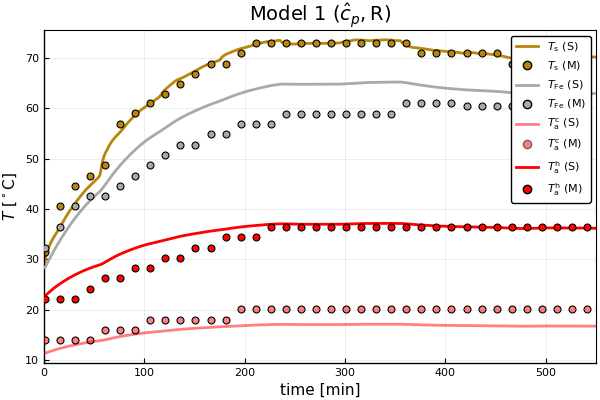

In [6]:
# MODEL 1: cp, Rr, Rs are Constant

# using Explicit forward Euler
function find_air_and_metal_temperatures(metal_temperatures,iterator)
    Tr,Ts,TFe = metal_temperatures
    
    # Solving algebraic equations first
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    Tac,Tad,Tah = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    
    # Forward Euler solver for ODE
    Tr = Tr + dt*(1.1*Rr*If[iterator]^2-UAr2d*(Tr-Tad))/(mr*chpCu)
    Ts = Ts + dt*(3*Rs*It[iterator]^2-UAs2Fe*(Ts-TFe))/(ms*chpCu)
    TFe = TFe + dt*(UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*chpFe)
    #
    return [Tr,Ts,TFe,Tac,Tad,Tah]
end
##
temp_array = zeros(6,N)
##
dt = 60 # Discretization time, s
#simulating model
x_initial = 28.,28.,28.
for iterator in 1:N
    temp_array[:,iterator] = find_air_and_metal_temperatures(x_initial, iterator)
    # Updating for next iteration
   x_initial = temp_array[1:3,iterator]
end
# Plottings
plt=plot()
# Tr simulated
#plot!(plt,temp_array[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:darkkhaki,lw=2)
# Ts simulated and measured
plot!(plt,temp_array[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,temp_array[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,temp_array[4,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

#plot!(plt,temp_array[5,:],label=L"T_\mathrm{a}^\mathrm{d}\ \mathrm{(S)}",lc=:red,lw=2,la=0.7)

plot!(plt,temp_array[6,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model1=plot!(title="Model 1 (\$\\hatc_p,\\mathrm{R}\$)",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,550),framestyle = :box, legend=:topright)
#plot(t_sim/60,Ts_meas_float,label=L"T_\mathrm{s}\ \mathrm{(M)}",lc=:darkgoldenrod,lw=3,ls=:dot)#,seriestype = :scatter )
#plot!(t_sim/60, Ts_sim, label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
#Model1Ts=plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,600),framestyle = :box)


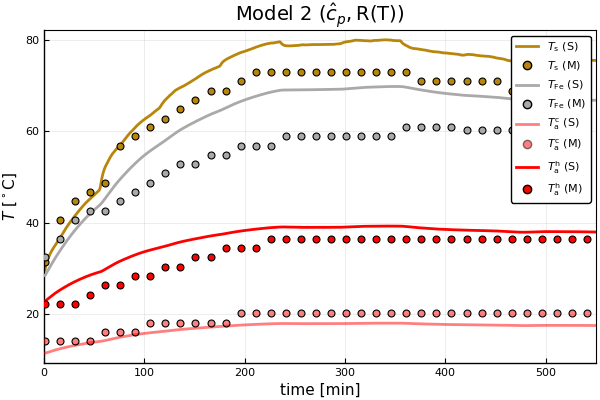

In [7]:
# MODEL 2: cp constant R(T)

# using Explicit forward Euler
function find_air_and_metal_temperatures(metal_temperatures,iterator)
    Tr,Ts,TFe = metal_temperatures
    
    # Solving algebraic equations first
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    Tac,Tad,Tah = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    
    # Forward Euler solver for ODE
    Tr = Tr + dt*(1.1*Rr*(1+alphaCu*(Tr-TCu_o))*If[iterator]^2-UAr2d*(Tr-Tad))/(mr*chpCu)
    Ts = Ts + dt*(3*Rs*(1+alphaCu*(Ts-TCu_o))*It[iterator]^2-UAs2Fe*(Ts-TFe))/(ms*chpCu)
    TFe = TFe + dt*(UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*chpFe)
    #
    return [Tr,Ts,TFe,Tac,Tad,Tah]
end
##
temp_array = zeros(6,N)
##
dt = 60 # Discretization time, s
#simulating model
x_initial = 28.,28.,28.
for iterator in 1:N
    temp_array[:,iterator] = find_air_and_metal_temperatures(x_initial, iterator)
    # Updating for next iteration
   x_initial = temp_array[1:3,iterator]
end
# Plottings
plt=plot()
# Tr simulated
#plot!(plt,temp_array[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:darkkhaki,lw=2)
# Ts simulated and measured
plot!(plt,temp_array[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,temp_array[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,temp_array[4,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

#plot!(plt,temp_array[5,:],label=L"T_\mathrm{a}^\mathrm{d}\ \mathrm{(S)}",lc=:red,lw=2,la=0.7)

plot!(plt,temp_array[6,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model2=plot!(title="Model 2 (\$\\hatc_p,\\mathrm{R(T)}\$)",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,550),framestyle = :box, legend=:topright)


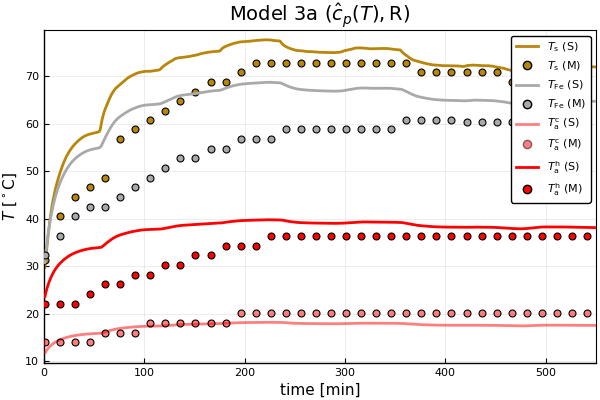

In [8]:
# MODEL 3: cp(T) constant R

# using Explicit forward Euler
function find_air_and_metal_temperatures(metal_temperatures,iterator)
    Tr,Ts,TFe = metal_temperatures
    
    # Solving algebraic equations first
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    Tac,Tad,Tah = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    
    # Forward Euler solver for ODE
    Tr = Tr + dt*(1.1*Rr*If[iterator]^2-UAr2d*(Tr-Tad))/(mr*R/MCu*(aCu+bCu*Tr))
    Ts = Ts + dt*(3*Rs*It[iterator]^2-UAs2Fe*(Ts-TFe))/(ms*R/MCu*(aCu+bCu*Ts))
    TFe = TFe + dt*(UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*R/MFe*(aFe+bFe*TFe))
    #
    return [Tr,Ts,TFe,Tac,Tad,Tah]
end
##
temp_array = zeros(6,N)
##
dt = 60 # Discretization time, s
#simulating model
x_initial = 28.,28.,28.
for iterator in 1:N
    temp_array[:,iterator] = find_air_and_metal_temperatures(x_initial, iterator)
    # Updating for next iteration
   x_initial = temp_array[1:3,iterator]
end
# Plottings
plt=plot()
# Tr simulated
#plot!(plt,temp_array[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:darkkhaki,lw=2)
# Ts simulated and measured
plot!(plt,temp_array[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,temp_array[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,temp_array[4,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

#plot!(plt,temp_array[5,:],label=L"T_\mathrm{a}^\mathrm{d}\ \mathrm{(S)}",lc=:red,lw=2,la=0.7)

plot!(plt,temp_array[6,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3a=plot!(title="Model 3a (\$\\hatc_p(T),\\mathrm{R}\$)",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,550),framestyle = :box, legend=:topright)


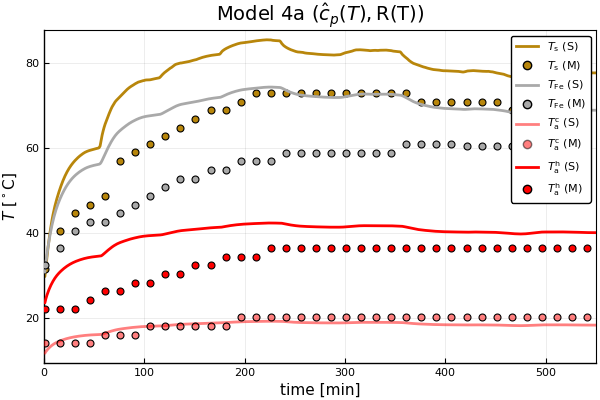

In [9]:
# MODEL 4: cp(T) constant R(T)

# using Explicit forward Euler
function find_air_and_metal_temperatures(metal_temperatures,iterator)
    Tr,Ts,TFe = metal_temperatures
    
    # Solving algebraic equations first
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+UAFe2a*(TFe-Tah)
        F[3] = Tac*(NStw-NSta*exp(-NStd))-NStd*Tah-NSta*(1-exp(-NStd))*Twc[iterator]
    end
    Tac,Tad,Tah = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    
    # Forward Euler solver for ODE
    Tr = Tr + dt*(1.1*Rr*(1+alphaCu*(Tr-TCu_o))*If[iterator]^2-UAr2d*(Tr-Tad))/(mr*R/MCu*(aCu+bCu*Tr))
    Ts = Ts + dt*(3*Rs*(1+alphaCu*(Ts-TCu_o))*It[iterator]^2-UAs2Fe*(Ts-TFe))/(ms*R/MCu*(aCu+bCu*Ts))
    TFe = TFe + dt*(UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*R/MFe*(aFe+bFe*TFe))
    #
    return [Tr,Ts,TFe,Tac,Tad,Tah]
end
##
temp_array = zeros(6,N)
##
dt = 60 # Discretization time, s
#simulating model
x_initial = 28.,28.,28.
for iterator in 1:N
    temp_array[:,iterator] = find_air_and_metal_temperatures(x_initial, iterator)
    # Updating for next iteration
   x_initial = temp_array[1:3,iterator]
end
# Plottings
plt=plot()
# Tr simulated
#plot!(plt,temp_array[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:darkkhaki,lw=2)
# Ts simulated and measured
plot!(plt,temp_array[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,temp_array[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,temp_array[4,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

#plot!(plt,temp_array[5,:],label=L"T_\mathrm{a}^\mathrm{d}\ \mathrm{(S)}",lc=:red,lw=2,la=0.7)

plot!(plt,temp_array[6,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4a=plot!(title="Model 4a (\$\\hatc_p(T),\\mathrm{R(T)}\$)",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,550),framestyle = :box, legend=:topright)


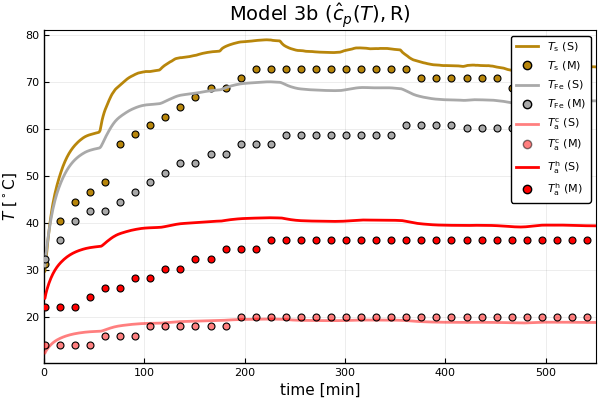

In [15]:
# MODEL 3b: cp(T) constant R considering heat exchanger also

# using Explicit forward Euler
function find_air_and_metal_temperatures(metal_temperatures,iterator)
    Tr,Ts,TFe = metal_temperatures
    
    # Solving algebraic equations first
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,5.)
        function heat_exchanger!(dT,T,par,t)
            # Counter-current 
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc[iterator]]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc[iterator]
        end
        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(5) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
    end
    Tac,Tad,Tah = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    
    # Forward Euler solver for ODE
    Tr = Tr + dt*(1.1*Rr*If[iterator]^2-UAr2d*(Tr-Tad))/(mr*R/MCu*(aCu+bCu*Tr))
    Ts = Ts + dt*(3*Rs*It[iterator]^2-UAs2Fe*(Ts-TFe))/(ms*R/MCu*(aCu+bCu*Ts))
    TFe = TFe + dt*(UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*R/MFe*(aFe+bFe*TFe))
    #
    return [Tr,Ts,TFe,Tac,Tad,Tah]
end
##
temp_array = zeros(6,N)
##
dt = 60 # Discretization time, s
#simulating model
x_initial = 28.,28.,28.
for iterator in 1:N
    temp_array[:,iterator] = find_air_and_metal_temperatures(x_initial, iterator)
    # Updating for next iteration
   x_initial = temp_array[1:3,iterator]
end
# Plottings
plt=plot()
# Tr simulated
#plot!(plt,temp_array[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:darkkhaki,lw=2)
# Ts simulated and measured
plot!(plt,temp_array[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,temp_array[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,temp_array[4,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

#plot!(plt,temp_array[5,:],label=L"T_\mathrm{a}^\mathrm{d}\ \mathrm{(S)}",lc=:red,lw=2,la=0.7)

plot!(plt,temp_array[6,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model3b=plot!(title="Model 3b (\$\\hatc_p(T),\\mathrm{R}\$)",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,550),framestyle = :box, legend=:topright)


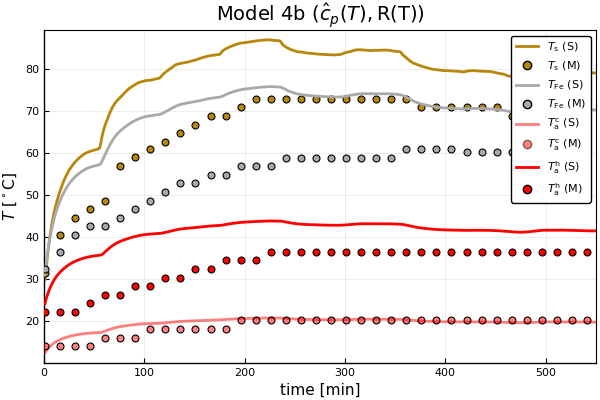

In [14]:
# MODEL 4b: cp(T) constant R(T)

# using Explicit forward Euler
function find_air_and_metal_temperatures(metal_temperatures,iterator)
    Tr,Ts,TFe = metal_temperatures
    
    # Solving algebraic equations first
    function algebraic_equation_solver!(F, z)
        Tac,Tad,Tah = z[1], z[2], z[3]
        F[1] = mda*R/Ma*((aa+ba*Tac)*Tac-(aa+ba*Tad)*Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*R/Ma*((aa+ba*Tad)*Tad-(aa+ba*Tah)*Tah)+UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,5.)
        function heat_exchanger!(dT,T,par,t)
            # Counter-current 
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc[iterator]]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc[iterator]
        end
        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(5) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
    end
    Tac,Tad,Tah = nlsolve(algebraic_equation_solver!,[Ta_o,Ta_o,Ta_o]).zero 
    
    # Forward Euler solver for ODE
    Tr = Tr + dt*(1.1*Rr*(1+alphaCu*(Tr-TCu_o))*If[iterator]^2-UAr2d*(Tr-Tad))/(mr*R/MCu*(aCu+bCu*Tr))
    Ts = Ts + dt*(3*Rs*(1+alphaCu*(Ts-TCu_o))*It[iterator]^2-UAs2Fe*(Ts-TFe))/(ms*R/MCu*(aCu+bCu*Ts))
    TFe = TFe + dt*(UAs2Fe*(Ts-TFe)-UAFe2a*(TFe-Tah)+QdFes)/(mFe*R/MFe*(aFe+bFe*TFe))
    #
    return [Tr,Ts,TFe,Tac,Tad,Tah]
end
##
temp_array = zeros(6,N)
##
dt = 60 # Discretization time, s
#simulating model
x_initial = 28.,28.,28.
for iterator in 1:N
    temp_array[:,iterator] = find_air_and_metal_temperatures(x_initial, iterator)
    # Updating for next iteration
   x_initial = temp_array[1:3,iterator]
end
# Plottings
plt=plot()
# Tr simulated
#plot!(plt,temp_array[1,:],label=L"T_\mathrm{r}\ \mathrm{(S)}",lc=:darkkhaki,lw=2)
# Ts simulated and measured
plot!(plt,temp_array[2,:],label=L"T_\mathrm{s}\ \mathrm{(S)}",lc=:darkgoldenrod,lw=2)
plot!(plt,idx,Ts_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgoldenrod, label=L"T_\mathrm{s}\ \mathrm{(M)}")
# TFe simulated and measured
plot!(plt,temp_array[3,:],label=L"T_\mathrm{Fe}\ \mathrm{(S)}",lc=:darkgrey,lw=2)
plot!(plt,idx,TFe_m[idx],st=:scatter,ms=5,msw=0.8,mc=:darkgrey, label=L"T_\mathrm{Fe}\ \mathrm{(M)}")

plot!(plt,temp_array[4,:],label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(S)}",lc=:red,lw=2,la=0.5)
plot!(plt,idx,Tac_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red,ma=:0.5,label=L"T_\mathrm{a}^\mathrm{c}\ \mathrm{(M)}")

#plot!(plt,temp_array[5,:],label=L"T_\mathrm{a}^\mathrm{d}\ \mathrm{(S)}",lc=:red,lw=2,la=0.7)

plot!(plt,temp_array[6,:],label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(S)}",lc=:red,lw=2,la=1)
plot!(plt,idx,Tah_m[idx],st=:scatter,ms=5,msw=0.8,mc=:red, label=L"T_\mathrm{a}^\mathrm{h}\ \mathrm{(M)}")

Model4b=plot!(title="Model 4b (\$\\hatc_p(T),\\mathrm{R(T)}\$)",xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,550),framestyle = :box, legend=:topright)


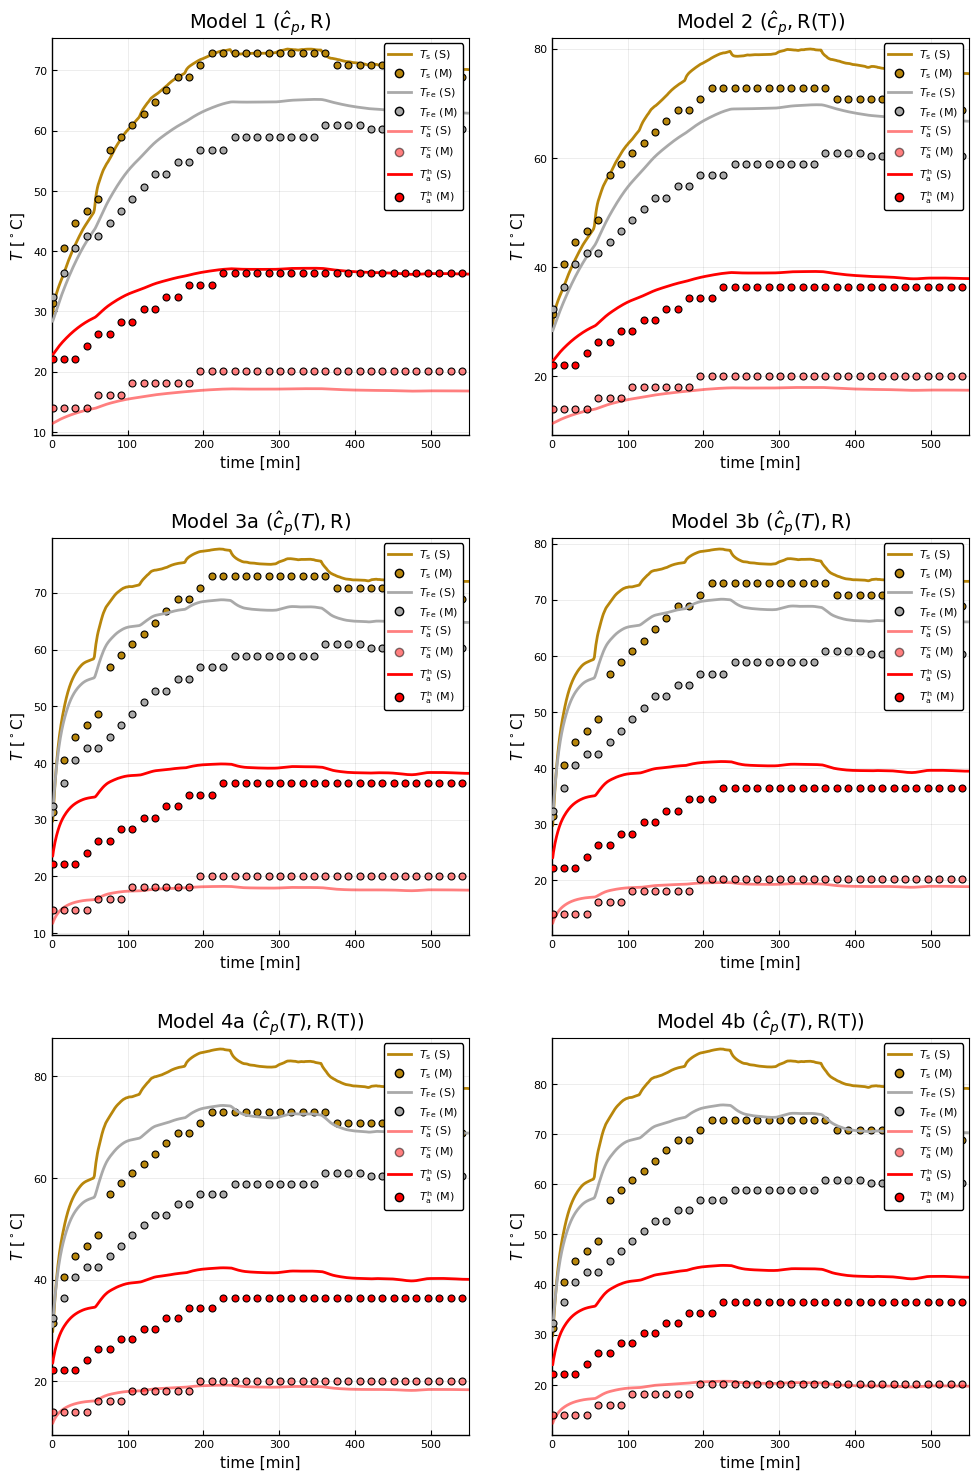

In [27]:
# Plotting for SIMS paper

figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter4/";
using Plots.PlotMeasures
using Plots
pyplot();
measured_data=plot(Model1, Model2, Model3a, Model3b, Model4a,Model4b,
        layout=grid(3,2),size = (1000, 1500),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm,legend=:topright)
figfile="modelVsimulator.svg"
savefig(figpath*figfile)